In [1]:
!pip install transformers
!pip install huggingface_hub
!pip install accelerate

!pip install bitsandbytes
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 11.3 MB/s eta 0:00:0000:0100:01


In [3]:
!pip install -U bitsandbytes

In [6]:
import torch
from datasets import load_dataset
import time

dataset = load_dataset("cais/mmlu", 'college_mathematics')
dataset

DatasetDict({
    test: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 11
    })
    dev: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 5
    })
})

In [4]:
from kaggle_secrets import UserSecretsClient
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_Token")

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [5]:
gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it",token=HF_TOKEN)
gemma_model = AutoModelForCausalLM.from_pretrained("google/gemma-2b-it", quantization_config=quantization_config,token=HF_TOKEN,device_map="auto")


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [7]:
# LLAMA
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct",token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct", quantization_config=quantization_config,token=HF_TOKEN,device_map="auto")


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [8]:
# Phi
phi_tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct",token=HF_TOKEN)
phi_model = AutoModelForCausalLM.from_pretrained("microsoft/Phi-3.5-mini-instruct", quantization_config=quantization_config,token=HF_TOKEN,device_map="auto")


tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

In [79]:
def run_inference(model, tokenizer, prompt, device):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        start_time = time.time()
        outputs = model.generate(**inputs,max_new_tokens=1024)
        inference_time = time.time() - start_time
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer[len(prompt):].strip(), inference_time

In [10]:
def chain_of_thought_prompt(question, options):
    prompt = f"Choose the answer to the given question from the options below.\nQuestion: {question}\nOptions:\n"
    for idx, option in enumerate(options, start=0):
        prompt += f"Option {idx}: {option}\n"
    prompt += "Think step by step to arrive at the correct option."
    return prompt

In [14]:
def evaluate_model(tokenizer, model, prompt_type, device): 
    total_time = 0
    correct_answers = 0
#     num_samples = len(dataset["test"])
    num_samples=30
    
    i = 0
    for sample in dataset["test"]:
        if i == num_samples:
            break
        i += 1
        question = sample["question"]
        options = sample["choices"]
        correct_answer = str(sample["answer"]).strip()
        
        if prompt_type == "chain_of_thought":
            prompt = chain_of_thought_prompt(question, options)
            generated_answer, inference_time = run_inference(model, tokenizer, prompt, device)
            print("generated ans:", generated_answer)
            processed_answer = extract_correct_option(generated_answer)
            if processed_answer is not None:
                processed_answer = str(processed_answer)
            else:
                processed_answer = "N/A" 
            
        print("processed_ans:", processed_answer)
        print("correct answer:", correct_answer)
        print("="*30)
        total_time += inference_time
        
        if processed_answer == correct_answer:
            correct_answers += 1
            print("Correct Answers So Far:", correct_answers)
        else:
            print("No match - Correct:", correct_answer, "Processed:", processed_answer)
        
    accuracy = correct_answers / num_samples
    avg_inference_time = total_time / num_samples
    return accuracy, avg_inference_time


In [15]:
import re

def extract_correct_option(generated_text):
    match = re.search(r"(?i)(correct answer|correct option).*?option\s*(\d+)", generated_text, re.DOTALL)
    print("Match from flexible pattern:", match)
    if not match:
        match = re.search(r"(?i)option\s*(\d+)", generated_text)
        print("Match from general 'Option X' pattern:", match)
    if match:
        return int(match.group(2) if match.lastindex == 2 else match.group(1))
    
    return None

# **COT- Phi**

**On 30 samples of dataset**

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Phi"
prompt_type = "chain_of_thought"
accuracy, avg_time = evaluate_model(phi_tokenizer,phi_model, prompt_type, device)
print(f"Model: {model_name}, Prompt: {prompt_type}, Accuracy: {accuracy}, Avg Inference Time: {avg_time} seconds")

You are not running the flash-attention implementation, expect numerical differences.


generated ans: To solve this problem, we need to analyze the behavior of the function f(x) = e^x + x - 2 on the interval [0, 1].

Step 1: Evaluate the function at the endpoints of the interval.
f(0) = e^0 + 0 - 2 = 1 - 2 = -1
f(1) = e^1 + 1 - 2 = e + 1 - 2 = e - 1

Since e is approximately 2.718, f(1) is positive (e - 1 > 0).

Step 2: Determine the derivative of the function to find critical points.
f'(x) = e^x + 1

Since e^x is always positive, f'(x) is always positive as well. This means the function is always increasing on the interval [0, 1].

Step 3: Analyze the function's behavior.
Since the function is always increasing on [0, 1], it can only cross the x-axis once within this interval. This is because an increasing function can only have one root if it crosses the x-axis.

Therefore, there is one real solution in the interval [0, 1], which means k = 1.

Since there is only one solution in the interval [0, 1], and the function is continuous and increasing, there must be another s

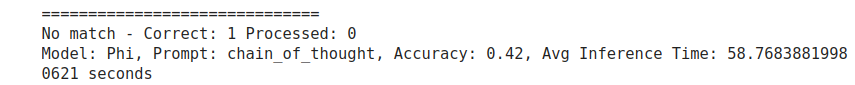

# **COT-Gemma**

In [17]:
def chain_of_thought_prompt(question, options):
    prompt = f"Choose the answer to the given question from the options below.\nQuestion: {question}\nOptions:\n"
    for idx, option in enumerate(options, start=0):
        prompt += f"Option {idx}: {option}\n"
    prompt += "Think step by step to arrive at the correct option by giving Answer : Option"
    return prompt

In [18]:
def evaluate_model(tokenizer, model, prompt_type, device): 
    total_time = 0
    correct_answers = 0
#     num_samples = len(dataset["test"])
    num_samples=30
    
    i = 0
    for sample in dataset["test"]:
        if i == num_samples:
            break
        i += 1
        question = sample["question"]
        options = sample["choices"]
        correct_answer = str(sample["answer"]).strip()
        
        if prompt_type == "chain_of_thought":
            prompt = chain_of_thought_prompt(question, options)
            generated_answer, inference_time = run_inference(model, tokenizer, prompt, device)
            print("generated ans:", generated_answer)
            processed_answer = extract_correct_option('Option '+generated_answer)
            if processed_answer is not None:
                processed_answer = str(processed_answer)
            else:
                processed_answer = "N/A" 
            
        print("processed_ans:", processed_answer)
        print("correct answer:", correct_answer)
        print("="*30)
        total_time += inference_time
        
        if processed_answer == correct_answer:
            correct_answers += 1
            print("Correct Answers So Far:", correct_answers)
        else:
            print("No match - Correct:", correct_answer, "Processed:", processed_answer)
        
    accuracy = correct_answers / num_samples
    avg_inference_time = total_time / num_samples
    return accuracy, avg_inference_time


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Gemma"
prompt_type = "chain_of_thought"
accuracy, avg_time = evaluate_model(gemma_tokenizer,gemma_model, prompt_type, device)
print(f"Model: {model_name}, Prompt: {prompt_type}, Accuracy: {accuracy}, Avg Inference Time: {avg_time} seconds")

generated ans: 1.

**Explanation:**

The equation can be rewritten as:

$$(e^x - 1)(x - 2) = 0$$

Setting each factor to zero, we get:

$$e^x = 1 \quad \text{or} \quad x = 2$$

Since x is in the interval [0, 1], only x = 2 is a solution.

Therefore, n = 1, and Option 1 is correct.
Match from flexible pattern: None
Match from general 'Option X' pattern: <re.Match object; span=(0, 8), match='Option 1'>
processed_ans: 1
correct answer: 1
Correct Answers So Far: 1
generated ans: 3.

**Answer:** Option 3

**Explanation:** An abelian group G of order 16 has the property that x + x + x + x = 0 for each x in G if and only if G is isomorphic to a direct sum of 4 cyclic groups of order 4.
Match from flexible pattern: None
Match from general 'Option X' pattern: <re.Match object; span=(0, 8), match='Option 3'>
processed_ans: 3
correct answer: 3
Correct Answers So Far: 2
generated ans: 3.

Answer: n = 2 and r = 6

Explanation:

The null space n of D consists of all polynomials p(x) in P such that p

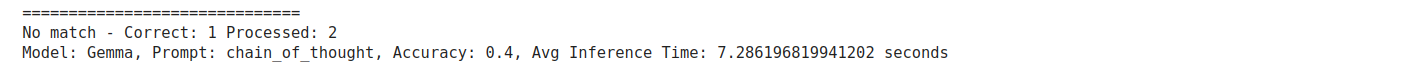

**On 5 samples**

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Gemma"
prompt_type = "chain_of_thought"
accuracy, avg_time = evaluate_model(gemma_tokenizer,gemma_model, prompt_type, device)
print(f"Model: {model_name}, Prompt: {prompt_type}, Accuracy: {accuracy}, Avg Inference Time: {avg_time} seconds")

generated ans: 1.

**Explanation:**

The equation can be rewritten as:

$$(e^x - 1)(x - 2) = 0$$

Setting each factor to zero, we get:

$$e^x = 1 \quad \text{or} \quad x = 2$$

Since x is in the interval [0, 1], only x = 2 is a solution.

Therefore, n = 1, and Option 1 is correct.
Match from flexible pattern: None
Match from general 'Option X' pattern: <re.Match object; span=(0, 8), match='Option 1'>
processed_ans: 1
correct answer: 1
Correct Answers So Far: 1
generated ans: 3.

**Answer:** Option 3

**Explanation:** An abelian group G of order 16 has the property that x + x + x + x = 0 for each x in G if and only if G is isomorphic to a direct sum of 4 cyclic groups of order 4.
Match from flexible pattern: None
Match from general 'Option X' pattern: <re.Match object; span=(0, 8), match='Option 3'>
processed_ans: 3
correct answer: 3
Correct Answers So Far: 2
generated ans: 3.

Answer: n = 2 and r = 6

Explanation:

The null space n of D consists of all polynomials p(x) in P such that p

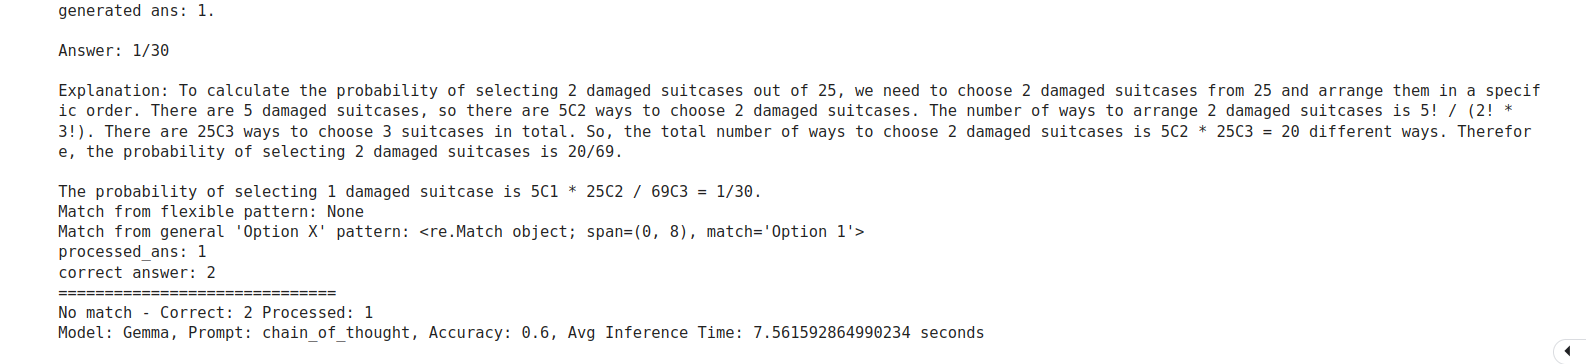

# **COT-LAMMA**

using COT prompt of gemma

In [96]:
def run_inference(model, tokenizer, prompt, device):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        start_time = time.time()
        outputs = model.generate(**inputs,max_new_tokens=256)
        inference_time = time.time() - start_time
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer[len(prompt):].strip(), inference_time

In [91]:
# def chain_of_thought_inference(question, options):
#     prompt = (
#         "For the question below, carefully consider each option before making a choice. "
#         "Use a step-by-step reasoning approach.\n"
#         f"Question: {question}\nOptions:\n"
#     )
#     opn = "\n".join([f"Option {i}: {choice}" for i, choice in enumerate(options, 1)])
#     prompt += opn
#     prompt += (
#         "\nReflect on the strengths and weaknesses of each option before selecting your final answer. "
#         "\nProvide your answer in the format: \"Answer: Option \"."
#     )
    
#     return prompt

In [94]:
import re

def extract_correct_option(generated_text):
    match = re.search(r"(?i)(correct answer|correct option).*?option\s*(\d+)", generated_text, re.DOTALL)
    print("Match from flexible pattern:", match)
    if not match:
        match = re.search(r"(?i)option\s*(\d+)", generated_text)
        print("Match from general 'Option X' pattern:", match)
    if match:
        return int(match.group(2) if match.lastindex == 2 else match.group(1))
    
    return None

In [103]:

def evaluate_model(tokenizer, model, prompt_type, device): 
    total_time = 0
    correct_answers = 0
#     num_samples = len(dataset["test"])
    num_samples=30
    
    i = 0
    for sample in dataset["test"]:
        if i == num_samples:
            break
        i += 1
        question = sample["question"]
        options = sample["choices"]
        correct_answer = str(sample["answer"]).strip()
        
        if prompt_type == "chain_of_thought":
            prompt = chain_of_thought_prompt(question, options)
            generated_answer, inference_time = run_inference(model, tokenizer, prompt, device)
            print("generated ans:", generated_answer)
            processed_answer = extract_correct_option('Option '+generated_answer)
            if processed_answer is not None:
                processed_answer = str(processed_answer)
            else:
                processed_answer = "N/A" 
            
        print("processed_ans:", processed_answer)
        print("correct answer:", correct_answer)
        print("="*30)
        total_time += inference_time
        
        if processed_answer == correct_answer:
            correct_answers += 1
            print("Correct Answers So Far:", correct_answers)
        else:
            print("No match - Correct:", correct_answer, "Processed:", processed_answer)
        
    accuracy = correct_answers / num_samples
    avg_inference_time = total_time / num_samples
    return accuracy, avg_inference_time


<function __main__.chain_of_thought_prompt(question, options)>

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Lamma"
prompt_type = "chain_of_thought"
accuracy, avg_time = evaluate_model(tokenizer,model, prompt_type, device)
print(f"Model: {model_name}, Prompt: {prompt_type}, Accuracy: {accuracy}, Avg Inference Time: {avg_time} seconds")

generated ans: 1: k = 1 and n = 0
Step 1: First, we need to understand the nature of the given equation, e^x + x - 2 = 0, and how its solutions behave in the interval [0, 1] and beyond.
Step 2: We know that the function e^x + x is increasing in the interval [0, 1] and beyond. This means that as x increases, the value of e^x + x also increases.
Step 3: To understand the behavior of the function e^x + x - 2, we can consider the value of e^x + x for x = 0. When x = 0, e^x + x = e^0 + 0 = 1. So, e^0 + 0 - 2 = 1 - 2 = -1. This tells us that the value of e^x + x - 2 is negative for x = 0.
Step 4: Since the function e^x + x is increasing, it means that for x > 0, e^x + x will be greater than 1. So, the function e^x + x - 2
Match from flexible pattern: None
Match from general 'Option X' pattern: <re.Match object; span=(0, 8), match='Option 1'>
processed_ans: 1
correct answer: 1
Correct Answers So Far: 1
generated ans: 1: 1
Step 1:  To find the number of additive abelian groups G of order 16 th

In [100]:
accuracy, avg_time = evaluate_model(tokenizer,model, prompt_type, device)
print(f"Model: {model_name}, Prompt: {prompt_type}, Accuracy: {accuracy}, Avg Inference Time: {avg_time} seconds")

generated ans: 2: k = n = 1
Step 1:  The given equation is e^x + x - 2 = 0. To find the number of real solutions in the interval [0, 1], we can start by analyzing the function f(x) = e^x + x - 2.
Step 2:  The function f(x) can be visualized as the sum of the exponential function e^x and the linear function x - 2. The graph of the exponential function e^x is always increasing and starts below the x-axis, while the linear function x - 2 starts below the x-axis as well.
Step 3:  We need to find the points of intersection between the two functions. Since e^x is always increasing, the point of intersection in the interval [0, 1] will be the only real solution, denoted as k = 1.
Step 4:  Now, we need to find the number of real solutions that are not in the interval [0, 1]. Since the exponential function e^x increases rapidly, there will be only one real solution that is not in the interval [0, 1], denoted as n = 1.
Step
Match from flexible pattern: None
Match from general 'Option X' pattern:

**On the set of 30 samples** <br>
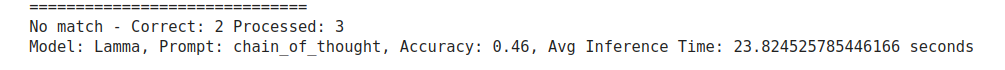

# REACT PROMPTING

In [60]:
!pip install langchain

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.2 requires cubinlinker, which is not installed.
cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.2 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.2 requ

In [62]:
!pip install langchain_community

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.8 MB/s eta 0:00:0000:010:01


In [141]:
from langchain import LLMMathChain, LLMChain, PromptTemplate
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.llms import HuggingFacePipeline
from langchain.agents import create_openai_functions_agent

In [142]:
from transformers import pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

llama_pipeline = pipeline(
    "text-generation",
    model=phi_model,
    tokenizer=phi_tokenizer,
    max_new_tokens=1024,
    do_sample=True,
    temperature=0.6
)

llm = HuggingFacePipeline(pipeline=llama_pipeline)

In [156]:
react_prompt_template = """
You are a highly intelligent agent capable of solving mathematics problems step by step. Your task is to answer questions by providing clear thoughts, actions, and observations until you reach the correct answer. Give correct option number as Final Answer at last.

Question: {question}

Let's proceed step by step.
"""

prompt_template = PromptTemplate(
    input_variables=["question"],
    template=react_prompt_template
)


In [157]:
tools = [
    Tool(
        name="math_solver",
        func=LLMMathChain(llm=llm).run,
        description="Use this tool to perform mathematical calculations when needed."
    )
]

react_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)


/opt/conda/lib/python3.10/site-packages/langchain/chains/llm_math/base.py:175: UserWarning: Directly instantiating an LLMMathChain with an llm is deprecated. Please instantiate with llm_chain argument or using the from_llm class method.
  warnings.warn(


In [158]:
def gen_prompt(question, options):
    prompt = f"Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.\n"
    prompt += f"Question: {question}\n"
    for i, option in enumerate(options):
        prompt += f"{i}: {option}\n"
    return prompt

In [159]:
def evaluate_phi_with_react_agent(agent, dataset, num_samples=5):
    results = []
    
    num_samples=5 
    i = 0
    for sample in dataset["test"]:
        if i == num_samples:
            break
        i += 1
        question = sample["question"]
        options = sample["choices"]
        correct_answer = sample["answer"]
                    
        print(f"\nEvaluating Question: {question}")
        prompt = gen_prompt(question,options)
        prompt = prompt_template.format(question=prompt) 
        
        try:
            # Use the ReAct agent to get the answer
            model_answer = agent.run(prompt)
        except Exception as e:
            model_answer = f"Error during inference: {e}"
        
        results.append({
            "question": question,
            "correct_answer": correct_answer,
            "model_answer": model_answer
        })
        print(f"Question: {question},Answer: {model_answer}")
        print("="*30)
    
    return results

# Running evaluation on 5 samples
phi_results = evaluate_phi_with_react_agent(react_agent, dataset, num_samples=5)

# # Display results
# import pandas as pd
# df_llama_results = pd.DataFrame(llama_results)
# print(df_llama_results)


Evaluating Question: Let k be the number of real solutions of the equation e^x + x - 2 = 0 in the interval [0, 1], and let n be the number of real solutions that are not in [0, 1]. Which of the following is true?
Question: Let k be the number of real solutions of the equation e^x + x - 2 = 0 in the interval [0, 1], and let n be the number of real solutions that are not in [0, 1]. Which of the following is true?,Answer: Error during inference: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Parsing LLM output produced both a final answer and a parse-able action:: Answer the following questions as best you can. You have access to the following tools:

math_solver(*args: Any, callbacks: Union[list[langchain_core.callbacks.base.BaseCallbackHandler], langchain_core.callbacks.base.BaseCallbackManager, NoneType] = None, tags: Optional[List[str]] = None, metadata: 

In [160]:
# Display results
import pandas as pd
df_phi_results = pd.DataFrame(phi_results)
print(df_phi_results)

                                            question  correct_answer  \
0  Let k be the number of real solutions of the e...               1   
1  Up to isomorphism, how many additive abelian g...               3   
2  Suppose P is the set of polynomials with coeff...               3   
3  The shortest distance from the curve xy = 8 to...               0   
4  There are 25 suitcases, 5 of which are damaged...               2   

                                        model_answer  
0  Error during inference: An output parsing erro...  
1  Error during inference: An output parsing erro...  
2  Error during inference: An output parsing erro...  
3  Error during inference: An output parsing erro...  
4  Error during inference: An output parsing erro...  


In [168]:
df_phi_res = pd.read_csv("/kaggle/input/phi-react-res/phi_react_result.csv")

In [171]:
correct = 0
total = len(df_phi_res)

for i in range(len(df_phi_res)):
    correct_ans = df_phi_res["correct_answer"][i]
    pred = df_phi_res["model_output"][i]
    if correct_ans == pred:
        correct += 1
Accuracy = correct/total
print(f"Accuracy for Phi-React-Agent: {Accuracy}")

Accuracy for Phi-React-Agent: 0.4


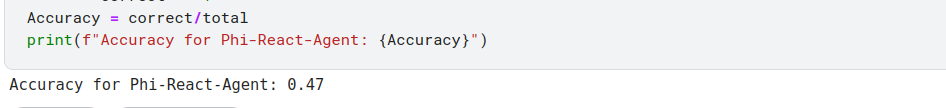

# Gemma-React Agent

In [172]:
from transformers import pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

llama_pipeline = pipeline(
    "text-generation",
    model=gemma_model,
    tokenizer=gemma_tokenizer,
    max_new_tokens=1024,
    do_sample=True,
    temperature=0.6
)

llm = HuggingFacePipeline(pipeline=llama_pipeline)
react_prompt_template = """
You are a highly intelligent agent capable of solving mathematics problems step by step. Your task is to answer questions by providing clear thoughts, actions, and observations until you reach the correct answer. Give correct option number as Final Answer at last.

Question: {question}

Let's proceed step by step.
"""

prompt_template = PromptTemplate(
    input_variables=["question"],
    template=react_prompt_template
)

tools = [
    Tool(
        name="math_solver",
        func=LLMMathChain(llm=llm).run,
        description="Use this tool to perform mathematical calculations when needed."
    )
]

react_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

def gen_prompt(question, options):
    prompt = f"Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.\n"
    prompt += f"Question: {question}\n"
    for i, option in enumerate(options):
        prompt += f"{i}: {option}\n"
    return prompt

def evaluate_gemma_with_react_agent(agent, dataset, num_samples=5):
    results = []
    
    num_samples=5 
    i = 0
    for sample in dataset["test"]:
        if i == num_samples:
            break
        i += 1
        question = sample["question"]
        options = sample["choices"]
        correct_answer = sample["answer"]
                    
        print(f"\nEvaluating Question: {question}")
        prompt = gen_prompt(question,options)
        prompt = prompt_template.format(question=prompt) 
        
        try:
            # Use the ReAct agent to get the answer
            model_answer = agent.run(prompt)
        except Exception as e:
            model_answer = f"Error during inference: {e}"
        
        results.append({
            "question": question,
            "correct_answer": correct_answer,
            "model_answer": model_answer
        })
        print(f"Question: {question},Answer: {model_answer}")
        print("="*30)
    
    return results

# Running evaluation on 5 samples
gemma_results = evaluate_gemma_with_react_agent(react_agent, dataset, num_samples=5)


In [ ]:
import pandas as pd
df_gemma_results = pd.DataFrame(gemma_results)
print(df_gemma_results)

In [173]:
correct = 0
total = len(df_gemma_res)

for i in range(len(df_gemma_res)):
    correct_ans = df_gemma_res["correct_answer"][i]
    pred = df_gemma_res["model_output"][i]
    if correct_ans == pred:
        correct += 1
Accuracy = correct/total
print(f"Accuracy for gemma_React-Agent: {Accuracy}")

Accuracy for Gemma-React-Agent: 0.4


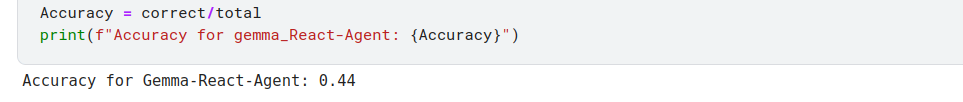

# LLAMA-REACT_AGENT

In [ ]:
from transformers import pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    do_sample=True,
    temperature=0.6
)

llm = HuggingFacePipeline(pipeline=llama_pipeline)
react_prompt_template = """
You are a highly intelligent agent capable of solving mathematics problems step by step. Your task is to answer questions by providing clear thoughts, actions, and observations until you reach the correct answer. Give correct option number as Final Answer at last.

Question: {question}

Let's proceed step by step.
"""

prompt_template = PromptTemplate(
    input_variables=["question"],
    template=react_prompt_template
)

tools = [
    Tool(
        name="math_solver",
        func=LLMMathChain(llm=llm).run,
        description="Use this tool to perform mathematical calculations when needed."
    )
]

react_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

def gen_prompt(question, options):
    prompt = f"Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.\n"
    prompt += f"Question: {question}\n"
    for i, option in enumerate(options):
        prompt += f"{i}: {option}\n"
    return prompt

def evaluate_llama_with_react_agent(agent, dataset, num_samples=5):
    results = []
    
    num_samples=5 
    i = 0
    for sample in dataset["test"]:
        if i == num_samples:
            break
        i += 1
        question = sample["question"]
        options = sample["choices"]
        correct_answer = sample["answer"]
                    
        print(f"\nEvaluating Question: {question}")
        prompt = gen_prompt(question,options)
        prompt = prompt_template.format(question=prompt) 
        
        try:
            # Use the ReAct agent to get the answer
            model_answer = agent.run(prompt)
        except Exception as e:
            model_answer = f"Error during inference: {e}"
        
        results.append({
            "question": question,
            "correct_answer": correct_answer,
            "model_answer": model_answer
        })
        print(f"Question: {question},Answer: {model_answer}")
        print("="*30)
    
    return results

# Running evaluation on 5 samples
llama_results = evaluate_llama_with_react_agent(react_agent, dataset, num_samples=5)


In [147]:
import pandas as pd
df_llama_results = pd.DataFrame(llama_results)
print(df_llama_results)

                                            question  correct_answer  \
0  Let k be the number of real solutions of the e...               1   
1  Up to isomorphism, how many additive abelian g...               3   
2  Suppose P is the set of polynomials with coeff...               3   
3  The shortest distance from the curve xy = 8 to...               0   
4  There are 25 suitcases, 5 of which are damaged...               2   

                                        model_answer  
0  Error during inference: An output parsing erro...  
1  Error during inference: An output parsing erro...  
2  Error during inference: An output parsing erro...  
3  Error during inference: An output parsing erro...  
4  Error during inference: An output parsing erro...  


In [155]:
print(dataset["test"]["choices"][1],dataset["test"]["answer"][1],df_llama_results["model_answer"][1])

['0', '1', '2', '3'] 3 Error during inference: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Parsing LLM output produced both a final answer and a parse-able action:: Answer the following questions as best you can. You have access to the following tools:

math_solver(*args: Any, callbacks: Union[list[langchain_core.callbacks.base.BaseCallbackHandler], langchain_core.callbacks.base.BaseCallbackManager, NoneType] = None, tags: Optional[List[str]] = None, metadata: Optional[Dict[str, Any]] = None, **kwargs: Any) -> Any - Use this tool to perform mathematical calculations when needed.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [math_solver]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Acti

In [174]:
correct = 0
total = len(df_llama_res)

for i in range(len(df_llama_res)):
    correct_ans = df_llama_res["correct_answer"][i]
    pred = df_llama_res["model_output"][i]
    if correct_ans == pred:
        correct += 1
Accuracy = correct/total
print(f"Accuracy for Llama_React-Agent: {Accuracy}")

Accuracy for Llama-React-Agent: 0.4


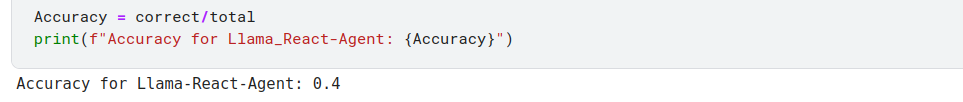

# ZERO-SHOT:

In [38]:
def zero_shot_prompt(question, options):
    prompt = f"Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.\n"
    prompt += f"Question: {question}\n"
    for i, option in enumerate(options):
        prompt += f"{i}: {option}\n"
    return prompt+"The best answer is"


def run_inference(model, tokenizer, prompt, device):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        start_time = time.time()
        outputs = model.generate(**inputs,max_new_tokens=3)
        inference_time = time.time() - start_time
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.strip(), inference_time

In [42]:
def evaluate_model(tokenizer, model, prompt_type, device): 
    total_time = 0
    correct_answers = 0
#     num_samples = len(dataset["test"])
    num_samples = 30
    i=0
    for sample in dataset["test"]:
        if i== num_samples:
            break
        i += 1
        question = sample["question"]
        options = sample["choices"]
        correct_answer = str(sample["answer"]).strip()
        
        if prompt_type == "zero_shot":
            prompt = zero_shot_prompt(question, options)
            generated_answer, inference_time = run_inference(model, tokenizer, prompt, device)
            print("generated ans:", generated_answer)
            processed_answer = extract_answer(generated_answer)
            if processed_answer is not None:
                processed_answer = processed_answer.strip()
            else:
                processed_answer = "N/A" 
            
        print("processed_ans:", processed_answer)
        print("correct answer:", correct_answer)
        print("="*30)
        total_time += inference_time
        
        if processed_answer == correct_answer:
            correct_answers += 1
            print("Correct Answers So Far:", correct_answers)
        else:
            print("No match - Correct:", correct_answer, "Processed:", processed_answer)
        
    accuracy = correct_answers / num_samples
    avg_inference_time = total_time / num_samples
    return accuracy, avg_inference_time


# Checking For Phi-3.5-mini-instruct

In [40]:
import re
def extract_answer(output_text):
    match = re.search(r"The best answer is.*?(\d+)", output_text)
    if match:
        return match.group(1)  
    return None  

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "phi_tokenizer"
prompt_type = "zero_shot"
accuracy, avg_time = evaluate_model(phi_tokenizer,phi_model, prompt_type, device)
print(f"Model: {model_name}, Prompt: {prompt_type}, Accuracy: {accuracy}, Avg Inference Time: {avg_time} seconds")

generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let k be the number of real solutions of the equation e^x + x - 2 = 0 in the interval [0, 1], and let n be the number of real solutions that are not in [0, 1]. Which of the following is true?
0: k = 0 and n = 1
1: k = 1 and n = 0
2: k = n = 1
3: k > 1
The best answer is: 1
processed_ans: 1
correct answer: 1
Correct Answers So Far: 1
generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Up to isomorphism, how many additive abelian groups G of order 16 have the property that x + x + x + x = 0 for each x in G ?
0: 0
1: 1
2: 2
3: 3
The best answer is 1.
processed_ans: 1
correct answer: 3
No match - Correct: 3 Processed: 1
generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Suppose P is the set of polynomials with coefficients in Z_5 and degree less than or equal t

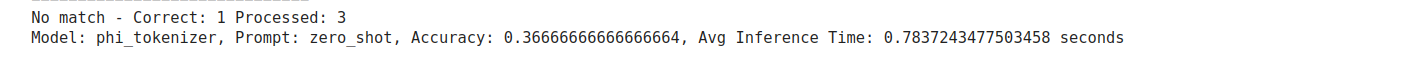

**Applied on whole dataset**

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_names = "phi_tokenizer"
prompt_type = "zero_shot"
accuracy, avg_time = evaluate_model(phi_tokenizer,phi_model, prompt_type, device)
print(f"Model: {model_name}, Prompt: {prompt_type}, Accuracy: {accuracy}, Avg Inference Time: {avg_time} seconds")

You are not running the flash-attention implementation, expect numerical differences.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let k be the number of real solutions of the equation e^x + x - 2 = 0 in the interval [0, 1], and let n be the number of real solutions that are not in [0, 1]. Which of the following is true?
0: k = 0 and n = 1
1: k = 1 and n = 0
2: k = n = 1
3: k > 1
The best answer is 1:
processed_ans: 1
correct answer: 1
Correct Answers So Far: 1
generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Up to isomorphism, how many additive abelian groups G of order 16 have the property that x + x + x + x = 0 for each x in G ?
0: 0
1: 1
2: 2
3: 3
The best answer is 1.
processed_ans: 1
correct answer: 3
No match - Correct: 3 Processed: 1
generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Suppose P is the set of polynomials with coefficients in Z_5 and degree less than or equal t

**Output of Zero-Shot Prompting on "Phi-3.5-mini-instruct"**

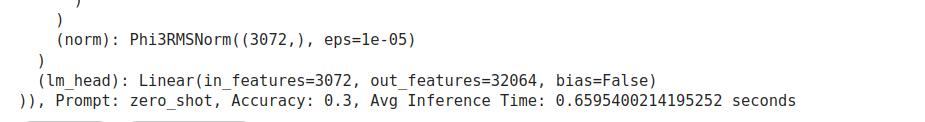

# Checking For Gemma

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Gemma"
prompt_type = "zero_shot"
accuracy, avg_time = evaluate_model(gemma_tokenizer,gemma_model, prompt_type, device)
print(f"Model: {model_name}, Prompt: {prompt_type}, Accuracy: {accuracy}, Avg Inference Time: {avg_time} seconds")


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let k be the number of real solutions of the equation e^x + x - 2 = 0 in the interval [0, 1], and let n be the number of real solutions that are not in [0, 1]. Which of the following is true?
0: k = 0 and n = 1
1: k = 1 and n = 0
2: k = n = 1
3: k > 1
The best answer is 1.
processed_ans: 1
correct answer: 1
Correct Answers So Far: 1
generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Up to isomorphism, how many additive abelian groups G of order 16 have the property that x + x + x + x = 0 for each x in G ?
0: 0
1: 1
2: 2
3: 3
The best answer is 3.
processed_ans: 3
correct answer: 3
Correct Answers So Far: 2
generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Suppose P is the set of polynomials with coefficients in Z_5 and degree less than or equal to 7. If t

# RESULT

**On 30 sample of dataset**
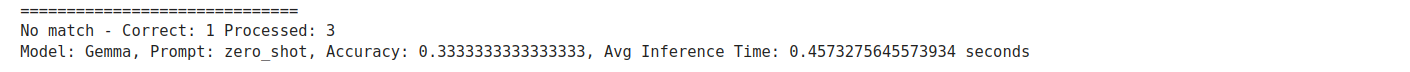

**Output For Zero-Shot Prompting on Gemma(On whole dataset):-**

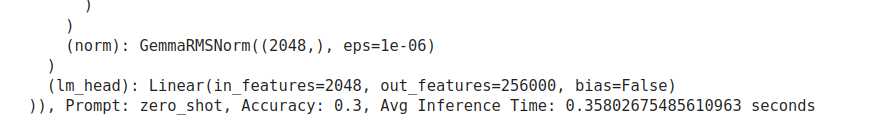

# **LLAMA_3.1-8B-Instruct : Zero-shot prompting**

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer.pad_token = tokenizer.eos_token
model_name = "LLAMA"
prompt_type = "zero_shot"
accuracy, avg_time = evaluate_model(tokenizer,model, prompt_type, device)
print(f"Model: {model_name}, Prompt: {prompt_type}, Accuracy: {accuracy}, Avg Inference Time: {avg_time} seconds")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let k be the number of real solutions of the equation e^x + x - 2 = 0 in the interval [0, 1], and let n be the number of real solutions that are not in [0, 1]. Which of the following is true?
0: k = 0 and n = 1
1: k = 1 and n = 0
2: k = n = 1
3: k > 1
The best answer is 1.
processed_ans: 1
correct answer: 1
Correct Answers So Far: 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Up to isomorphism, how many additive abelian groups G of order 16 have the property that x + x + x + x = 0 for each x in G?
0: 0
1: 1
2: 2
3: 3
The best answer is 1.
processed_ans: 1
correct answer: 3
No match - Correct: 3 Processed: 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Suppose P is the set of polynomials with coefficients in Z_5 and degree less than or equal to 7. If the operator D sends p(x) in P to its derivative p′(x), what are the dimensions of the null space n and range r of D?
0: n = 1 and r = 6
1: n = 1 and r = 7
2: n = 2 and r = 5
3: n = 2 and r = 6
The best answer is 3.
processed_ans: 3
correct answer: 3
Correct Answers So Far: 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: The shortest distance from the curve xy = 8 to the origin is
0: 4
1: 8
2: 16
3: 2sqrt(2)
The best answer is 0.
processed_ans: 0
correct answer: 0
Correct Answers So Far: 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: There are 25 suitcases, 5 of which are damaged. Three suitcases are selected at random. What is the probability that exactly 2 are damaged?
0: 2/69
1: 1/30
2: 2/23
3: 12/125
The best answer is 3.
processed_ans: 3
correct answer: 2
No match - Correct: 2 Processed: 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let (Z_{10}, +, x) be the ring of integers modulo 10, and let S be the subset of Z_{10} represented by {0, 2, 4, 6, 8}. Which of the following statements is FALSE?
0: (S, +, x) is closed under addition modulo 10.
1: (S, +, x) is closed under multiplication modulo 10.
2: (S, +, x) has an identity under addition modulo 10.
3: (S, +, x) has no identity under multiplication modulo 10.
The best answer is 3.
processed_ans: 3
correct answer: 3
Correct Answers So Far: 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: A ladder 9 meters in length is leaning against a vertical wall on level ground. As the bottom end of the ladder is moved away from the wall at a constant rate of 2 meters per second, the top end slides downward along the wall. How fast, in meters per second, will the top end of the ladder be sliding downward at the moment the top end is 3 meters above the ground?
0: 12*sqrt(2)
1: 6*sqrt(2)
2: 4*sqrt(2)
3: 1/(2*sqrt(2))
The best answer is 2.
processed_ans: 2
correct answer: 2
Correct Answers So Far: 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Consider a segment of length 10. Points A and B are chosen randomly such that A and B divide the segment into three smaller segments. What is the probability that the three smaller segments could form the sides of a triangle?
0: 0
1: 10%
2: 25%
3: 50%
The best answer is 0.
processed_ans: 0
correct answer: 2
No match - Correct: 2 Processed: 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let V be a finite-dimensional real vector space and let P be a linear transformation of V such that P^2 = P. Which of the following must be true?
I. P is invertible.
II. P is diagonalizable.
III. P is either the identity transformation or the zero transformation.
0: None
1: I only
2: II only
3: III only
The best answer is 3.
processed_ans: 3
correct answer: 2
No match - Correct: 2 Processed: 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Which of the following is true?
0: Every compact space is complete
1: Every complete space is compact
2: Neither (a) nor (b).
3:  Both (a) and (b).
The best answer is 0.
processed_ans: 0
correct answer: 0
Correct Answers So Far: 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: A discrete graph is complete if there is an edge connecting any pair of vertices. How many edges does a complete graph with 10 vertices have?
0: 10
1: 20
2: 25
3: 45
The best answer is 2.
processed_ans: 2
correct answer: 3
No match - Correct: 3 Processed: 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Suppose X is a discrete random variable on the set of positive integers such that for each positive integer n, the probability that X = n is 1/2^n. If Y is a random variable with the same probability distribution and X and Y are independent, what is the probability that the value of at least one of the variables X and Y is greater than 3?
0: 1/64
1: 15/64
2: 1/4
3: 3/8
The best answer is 1.
processed_ans: 1
correct answer: 1
Correct Answers So Far: 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let V and W be 4-dimensional subspaces of a 7-dimensional vector space X. Which of the following CANNOT be the dimension of the subspace V intersect W?
0: 0
1: 1
2: 2
3: 3
The best answer is 3.
processed_ans: 3
correct answer: 0
No match - Correct: 0 Processed: 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: A large class is to be divided into teams and each student must be a member of exactly one team. However, each student dislikes three of their classmates. Dislike between students need not be mutual. If the teams do not need to be equally sized, how many must be created so that no student is the teammate of someone they dislike?
0: 4
1: 7
2: 10
3: 13
The best answer is 2.
processed_ans: 2
correct answer: 1
No match - Correct: 1 Processed: 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Sofia and Tess will each randomly choose one of the 10 integers from 1 to 10. What is the probability that neither integer chosen will be the square of the other?
0: 0.64
1: 0.72
2: 0.81
3: 0.95
The best answer is 2.
processed_ans: 2
correct answer: 3
No match - Correct: 3 Processed: 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let K be a nonempty subset of R^n, where n > 1. Which of the following statements must be true?
I. If K is compact, then every continuous real-valued function defined on K is bounded.
II. If every continuous real-valued function defined on K is bounded, then K is compact.
III. If K is compact, then K is connected.
0: I only
1: II only
2: III only
3: I and II only
The best answer is 2.
processed_ans: 2
correct answer: 3
No match - Correct: 3 Processed: 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Suppose V is a real vector space of finite dimension n. Call the set of matrices from V into itself M(V). Let T be in M(V). Consider the two subspaces U = {X ∈ M(V) : TX = XT} and W = {TX − XT : X ∈ M(V)}. Which of the following must be TRUE?
I. If V has a basis containing only eigenvectors of T then U = M(V).
II. dim (U) + dim (W) = n^2
III. dim (U) < n
0: I only
1: II only
2: III only
3: I and II only
The best answer is 1.
processed_ans: 1
correct answer: 1
Correct Answers So Far: 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let F be a constant unit force that is parallel to the vector (-1, 0, 1) in xyz-space. What is the work done by F on a particle that moves along the path given by (t, t^2, t^3) between time t=0 and time t=1?
0: -1/4
1: -1/(4sqrt(2))
2: 0
3: sqrt(2)
The best answer is 0.
processed_ans: 0
correct answer: 2
No match - Correct: 2 Processed: 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let X be a topological space, and let A, B, and C be nonempty subsets of X such that A c B c C; that is, A is a proper subset of B, and B is a proper subset of C. Which of the following statements is (are) true?
I. If A and C are connected, then B is connected.
II. If A and C are compact, then B is compact.
III. If A and C are Hausdorff, then B is Hausdorff.
0: I and II only
1: III only
2: I and III only
3: I, II, and III
The best answer is 3.
processed_ans: 3
correct answer: 3
Correct Answers So Far: 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let x_1 = 1 and x_(n+1) = sqrt(3+2x_n) for all positive integers n. If it is assumed that {x_n} converges, then lim x_n =
0: 3
1: e
2: sqrt(5)
3: 0
The best answer is 2.
processed_ans: 2
correct answer: 0
No match - Correct: 0 Processed: 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: If v is an eigenvector of an invertible matrix A, then which of the following is I are necessarily
true?
I. v is also an eigenvector of 2A.
II. v is also an eigenvector of A^2.
III. v is also an eigenvector of A^(-1).
0: I only
1: II only
2: III only
3: I, II, and III
The best answer is 3.
processed_ans: 3
correct answer: 3
Correct Answers So Far: 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: For how many positive integers k does the ordinary decimal representation of the integer k! end in exactly 99 zeros?
0: None
1: One
2: Four
3: Five
The best answer is 2.
processed_ans: 2
correct answer: 3
No match - Correct: 3 Processed: 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let R be a ring with a multiplicative identity. If U is an additive subgroup of R such that ur in U for all u in U and for all r in R, then U is said to be a right ideal of R. If R has exactly two right ideals, which of the following must be true?
I. R is commutative.
II. R is a division ring (that is, all elements except the additive identity have multiplicative inverses).
III. R is infinite.
0: I only
1: II only
2: III only
3: I and II only
The best answer is 0.
processed_ans: 0
correct answer: 1
No match - Correct: 1 Processed: 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: A six-sided die (whose faces are numbered 1 through 6, as usual) is known to be counterfeit: The probability of rolling any even number is twice the probability of rolling any odd number. What is the probability that if this die is thrown twice, the first roll will be a 5 and the second roll will be a 6?
0: 2/81
1: 1/18
2: 2/27
3: 1/9
The best answer is 3.
processed_ans: 3
correct answer: 0
No match - Correct: 0 Processed: 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Statement 1 | Suppose {s_n} and {t_n} are sequences of complex numbers such that lim_n→∞ s_n = s and lim_n→∞ tn = t. lim_n→∞ s_nt_n = st. Statement 2 | There exists a bounded sequence of real numbers with no convergent subsequence.
0: True, True
1: True, False
2: False, True
3: False, False
The best answer is: 0
processed_ans: 0
correct answer: 1
No match - Correct: 1 Processed: 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Define a binary operation on Z, the set of integers, by the equation m • n = m + n + mn. Which of
the following statements is (are) true about the binary structure (Z, • )?
I. This structure is not a group since the operation is not associative.
II. This structure is not a group since there is no identity element.
III. This structure is not a group since not all elements have an inverse.
IV. This structure is a group.
0: I and II only
1: I and III only
2: II and III only
3: III only
The best answer is 3.
processed_ans: 3
correct answer: 3
Correct Answers So Far: 11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: It takes Kate k days to write a GRE math practice test. It takes John j days to write a GRE math practice test. If Kate and John work on a practice test in alternating 2-day shifts, it takes them 10 days when Kate starts and 10.5 days when John starts. How long would it take the two to complete a practice test if Kate and John worked simultaneously?
0: 9/2 days
1: 5 days
2: 41/8 days
3: 36/7 days
The best answer is 0.
processed_ans: 0
correct answer: 3
No match - Correct: 3 Processed: 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: What is the greatest possible area of a triangular region with one vertex at the center of a circle of radius 1 and the other two vertices on the circle?
0: 1/2
1: 1
2: sqrt(2)
3: pi
The best answer is 3.
processed_ans: 3
correct answer: 0
No match - Correct: 0 Processed: 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: Let f(x,y) = x^2 - 2xy + y^3 for all real x and y. Which of the following is true?
0: f has all of its relative extrema on the line x = y.
1: f has all of its relative extrema on the parabola x = y^2.
2: f has a relative minimum at (0, 0).
3: f has an absolute minimum at (2/3, 2/3).
The best answer is 3.
processed_ans: 3
correct answer: 0
No match - Correct: 0 Processed: 3
generated ans: Provide only the correct option number (0, 1, 2, or 3) as your answer. Do not explain.
Question: What is the largest order of an element in the group of permutations of 5 objects?
0: 5
1: 6
2: 12
3: 15
The best answer is 2.
processed_ans: 2
correct answer: 1
No match - Correct: 1 Processed: 2
Model: LLAMA, Prompt: zero_shot, Accuracy: 0.36666666666666664, Avg Inference Time: 1.3238067865371703 seconds


**On 30 sample:-** <br>
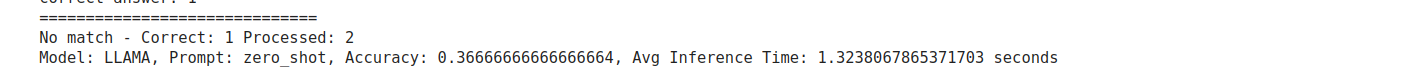

**Output For Zero-Shot Prompting on Meta-Llama-3.1-8B-Instruct(On whole dataset):-**

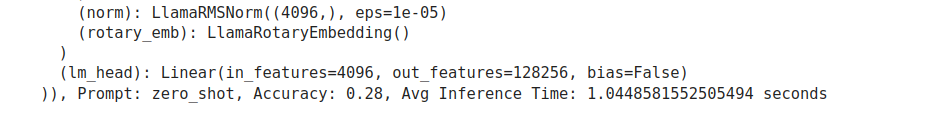

# **Reasons:**

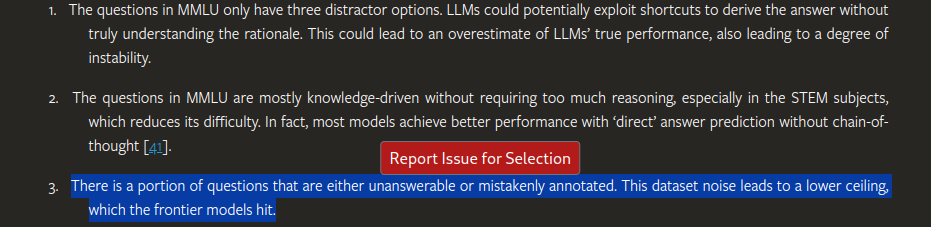

**Ref:** 1. [https://arxiv.org/html/2406.01574v4](http://) <br>
2. [https://huggingface.co/blog/open-llm-leaderboard-mmlu](http://) <br>
3. [https://github.com/FranxYao/chain-of-thought-hub/blob/main/MMLU/readme.md](http://) <br>